In [1]:
!pip install normflows

  Preparing metadata (setup.py) ... done
  Created wheel for normflows: filename=normflows-1.7.3-py2.py3-none-any.whl size=87244 sha256=f77eca9fe90460b34a30d174296a5202d89415e1184afb59066c4f5524cd8605
  Stored in directory: /home/bapi_cms/.cache/pip/wheels/34/b2/f3/e97b5a749e1b93adfdca027b9050d0ee4d4790c5a5dec45a6d
Successfully built normflows


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import normflows as nf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

RealNVP Implementation Using normflows

In [2]:
dim = 2  # Dimensionality of the input space
hidden = 64  # Hidden layer size for MLPs in the flow
num_layers = 4  # Number of flow layers

# Base distribution (standard normal)
base = nf.distributions.base.DiagGaussian(dim)

# Define list of flows
flows = []

for i in range(num_layers):
    # MLP takes in 1D input and returns 2D output (scale and shift)
    param_map = nf.nets.MLP([dim // 2, hidden, hidden, dim // 2 * 2], init_zeros=True)

    # Affine coupling block splits input and applies transform to half
    flows.append(nf.flows.AffineCouplingBlock(param_map))

    # Permute dimensions (to alternate which half is transformed)
    flows.append(nf.flows.Permute(dim, mode='swap'))

# Construct the model
model = nf.NormalizingFlow(base, flows)

In [3]:
dir(nf.flows)

['ActNorm',
 'AffineConstFlow',
 'AffineCoupling',
 'AffineCouplingBlock',
 'AutoregressiveRationalQuadraticSpline',
 'BatchNorm',
 'CCAffineConst',
 'CircularAutoregressiveRationalQuadraticSpline',
 'CircularCoupledRationalQuadraticSpline',
 'Composite',
 'CoupledRationalQuadraticSpline',
 'Flow',
 'GlowBlock',
 'HamiltonianMonteCarlo',
 'Invertible1x1Conv',
 'InvertibleAffine',
 'LULinearPermute',
 'MaskedAffineAutoregressive',
 'MaskedAffineFlow',
 'Merge',
 'MetropolisHastings',
 'PeriodicShift',
 'PeriodicWrap',
 'Permute',
 'Planar',
 'Radial',
 'Residual',
 'Reverse',
 'Split',
 'Squeeze',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'affine',
 'base',
 'mixing',
 'neural_spline',
 'normalization',
 'periodic',
 'planar',
 'radial',
 'reshape',
 'residual',
 'stochastic']

In [5]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [6]:
import json

filename="blobs.json"
with open(filename, 'r') as file:
    data = json.load(file)
Data=torch.tensor(data['X'])

# Compute the mean
mean_x = Data.mean(axis=0)

# Center the data
X_centered = Data - mean_x
x_data = torch.tensor(X_centered, dtype=torch.float32).to(device)

/tmp/ipykernel_32968/3145824197.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data = torch.tensor(X_centered, dtype=torch.float32).to(device)


100%|██████████| 10000/10000 [01:06<00:00, 150.98it/s]


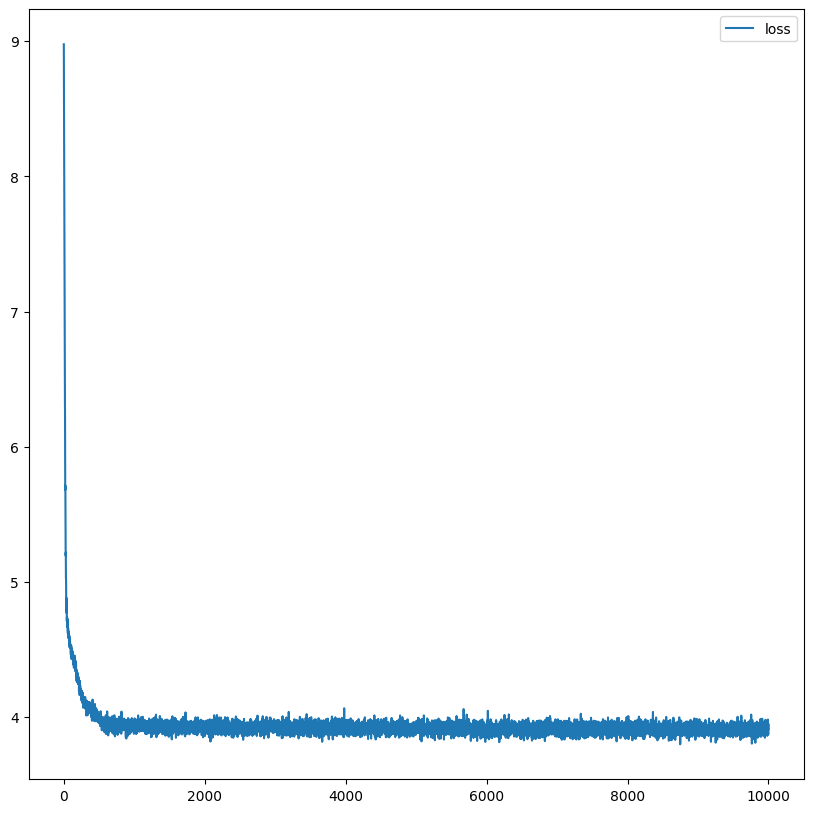

In [7]:
# Train model
max_iter = 10000  # Number of iterations for training
num_samples = 1000  # Number of samples to draw from the dataset for each iteration
show_iter = 1000  # Frequency of showing the loss


loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()



    # Select the sampled points using the generated indices
    x = x_data[torch.randint(0, x_data.shape[0], (num_samples,))].to(device)

    # Compute loss
    loss = model.forward_kld(x)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()

    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())


# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

In [8]:
with torch.no_grad():
    z = model.forward(x_data)

In [11]:
# z_samples = z.cpu().numpy()
# x_generated = model.inverse(z_samples).cpu().numpy()

z_samples = z.cpu().numpy()  # You can keep this if you need it later for plotting

# Convert back to tensor for inverse pass
z_tensor = torch.tensor(z_samples, dtype=torch.float32).to(device)

# Invert the flow
# x_generated = model.inverse(z_tensor).cpu().numpy()

x_generated = model.inverse(z_tensor).detach().cpu().numpy()


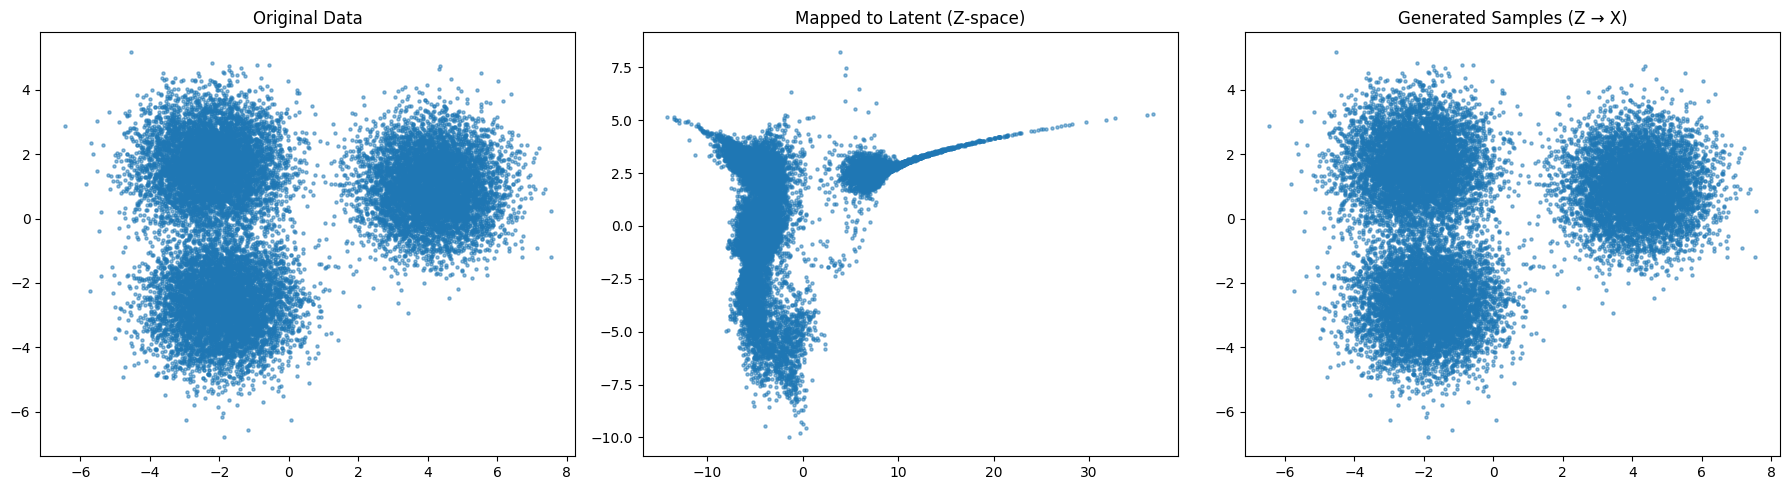

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].scatter(X_centered[:, 0], x_data[:, 1], s=5, alpha=0.5)
axs[0].set_title("Original Data")

axs[1].scatter(z[:, 0], z[:, 1], s=5, alpha=0.5)
axs[1].set_title("Mapped to Latent (Z-space)")

axs[2].scatter(x_generated[:, 0], x_generated[:, 1], s=5, alpha=0.5)
axs[2].set_title("Generated Samples (Z → X)")

plt.tight_layout()
plt.show()